In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
client = pd.read_csv("clients.csv")
transaction = pd.read_csv("transactions.csv")

C:\Users\Mohammed\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (14,17) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
client.head()

,banque,agence,generic,plural,ccle,pnb,code_ville,ville,flag_etranger_res_maroc,flag_proprietaire_logement,...,flag_app_mobile,sexe,date_naissance,salary,profession,nombre_enfant,marital_status,date_eer,segment,id
0,1,2,21111,0,9,"1022,21",10,AGADIR,N,N,...,N,Homme,19571210.0,0,NaN,NaN,3,07/05/1991,PARTICULIER,87631
1,1,2,21111,0,6,"224,41",10,AGADIR,N,N,...,N,Homme,19610505.0,0,NaN,NaN,3,20/05/1991,PARTICULIER,120851
2,1,2,21111,0,7,"23940,36",10,AGADIR,N,N,...,O,Homme,19680101.0,10000,NaN,2.0,3,07/06/1991,PARTICULIER,28206
3,1,2,21111,0,3,"9,45",10,AGADIR,N,N,...,N,Homme,19660910.0,0,NaN,NaN,3,25/11/1991,PARTICULIER,144072
4,1,2,21111,0,2,"1393,3",240,ESSAOUIRA,N,N,...,N,Homme,19840119.0,3000,NaN,NaN,1,30/05/2005,PARTICULIER,78120


In [5]:
transaction.head()

,ANNEE,MOIS,SEMAINE,NBRE_TRANSACTION,MONTANT,SENS_TRANSACTION,DWP,id
0,2017,11,44,3,-2104.0,Débit,201711,54654
1,2017,11,44,1,-3.0,Débit,201711,49846
2,2017,11,44,1,-1.0,Débit,201711,191415
3,2017,11,44,1,-1200.0,Débit,201711,189507
4,2017,11,44,3,-900.0,Débit,201711,5319


# Pre-processing

### Missing values

In [10]:
client.isnull().sum()

banque                             0
agence                             0
generic                            0
plural                             0
ccle                               0
pnb                            13083
code_ville                         0
ville                              0
flag_etranger_res_maroc            0
flag_proprietaire_logement         0
secteur_activite                   0
flag_app_mobile                    0
sexe                            1649
date_naissance                  1091
salary                             0
profession                    242280
nombre_enfant                  96823
marital_status                  1091
date_eer                           0
segment                            0
id                                 0
dtype: int64

### Duplicate

In [14]:
client.duplicated().sum()

27

# Create the feautures

### List of date (By 6 months)

In [15]:
listid = client['id'].unique()
listdates = [201707, 201710, 201801, 201804, 201807, 201810, 201901, 201904, 201907, 201910]

### Age

In [16]:
def compute_int_age_at_timestamp(df, list_clients, list_dates):
    df.loc[df.date_naissance < 19000000,'date_naissance'] = None
    df_clients = df[df.id.isin(list_clients)][['id', 'date_naissance']]
    df_clients.date_naissance = pd.to_datetime(df_clients.date_naissance, format='%Y%m%d')
    df_dates = pd.DataFrame(list_dates, columns=['DWP'])
    df_res = df_dates.assign(temp=1).merge(df_clients.assign(temp=1)).drop("temp", 1)
    df_res['AGE'] = df_res.DWP // 100 - df_res.date_naissance.dt.year

    return df_res[['DWP', 'id', 'AGE']]

In [17]:
df_AGE=compute_int_age_at_timestamp(client, listid, listdates)

In [18]:
df_AGE.head(4)

,DWP,id,AGE
0,201707,87631,60.0
1,201707,120851,56.0
2,201707,28206,49.0
3,201707,144072,51.0


### Select the six dominant cities and binarise them

In [19]:
def binarise_top_n(df, column, replacement, number):
    top_cities = df[column].value_counts().head(number).index
    other_cities = list(set(df[column]) - set(top_cities))
    one_hot_encoded_data = pd.get_dummies(df[column].replace(other_cities, replacement))
    one_hot_encoded_data['ID'] = df.id
    return one_hot_encoded_data

In [20]:
df_VILLE = binarise_top_n(client, 'ville', 'AUTRE', 6)

In [22]:
df_VILLE.head(3)

,AUTRE,CASABLANCA,FES,MARRAKECH,RABAT,SALE,TANGER,ID
0,1,0,0,0,0,0,0,87631
1,1,0,0,0,0,0,0,120851
2,1,0,0,0,0,0,0,28206


### Binarise the marital status

In [24]:
def binarise_marital_status(df, marital_status, list_clients):
    """
   :param df: pandas DataFrame
   :param marital_status: categorical variable
   :param list_clients: list of customers
   :return: pandas DataFrame
   """
    # Map values of column marital_status according to input correspondence
    clients_df = df[df.id.isin(list_clients)]
    clients_df[marital_status] = clients_df[marital_status].map(
        {1.0: 'SINGLE', '1': 'SINGLE', 2.0: 'DIVORCED', '2': 'DIVORCED', 3.0: 'MARRIED', '3': 'MARRIED', 4.0: 'WIDOWED',
         '4': 'WIDOWED', 9.0: 'OTHER', '9': 'OTHER', 'PARTNER': 'OTHER', np.nan: 'OTHER'})

    # Dummify column marital_status
    df_res = pd.DataFrame(pd.get_dummies(clients_df[marital_status]))
    df_res['ID'] = clients_df.id
    return df_res

In [25]:
df_MARITAL = binarise_marital_status(client, 'marital_status', listid)

In [28]:
df_MARITAL.head()

,DIVORCED,MARRIED,OTHER,SINGLE,WIDOWED,ID
0,0,1,0,0,0,87631
1,0,1,0,0,0,120851
2,0,1,0,0,0,28206
3,0,1,0,0,0,144072
4,0,0,0,1,0,78120


### PNB

In [30]:
def PNB(df):
    df.pnb=client.pnb.astype(str).map(lambda x:x.replace(",","."))
    df.pnb.astype(float)
    df.drop_duplicates("id", inplace = True)
    return(df[["id","pnb"]])

In [31]:
df_PNB = PNB(client)

In [32]:
df_PNB.head()

,id,pnb
0,87631,1022.21
1,120851,224.41
2,28206,23940.36
3,144072,9.45
4,78120,1393.3


### Credit / Debit (Merge databases (client & transaction)

In [33]:
from functools import reduce

def compute_credit_debit_unstacked(data, list_dwp, timelag_n, aggreg):
    """
    Compute credit or debit amounts of last N months for each dwp
    :param data: pandas DataFrame
    :param list_dwp: list of dates in format int, e.g, "201601"
    :param aggreg: pandas DataFrame
    :param timelag: list of unique RADICAUX
    :param timelag_n: int that indicates the number of previous months to take

    """
    to_merge = pd.DataFrame()
    for i in range(len(list_dwp)):
        filter_col = [col for col in data if (col <= list_dwp[i])]
        datatemp = data[filter_col]
        datatemp = datatemp[datatemp.columns[-timelag_n:]]
        datatemp.columns = map((aggreg + '_{}_MONTH_AGO').format, range(timelag_n, 0, -1))
        datatemp['DWP'] = list_dwp[i]
        datatemp.set_index('DWP', append=True, inplace=True)
        to_merge = pd.concat([to_merge, datatemp])

    return to_merge.reset_index()

In [34]:
def credit_last_n_months(df_transactions, list_clients, list_dwp, timelag_n, aggreg):
    """
    Return credit amounts on last n months
    :param df_transactions: pandas DataFrame
    :param df_clients: pandas DataFrame
    :param list_clients: list of unique RADICAUX
    :param list_dwp: list of dates in format int, e.g, "201601"
    :param timelag_n: int that indicates the number of previous months to take
    :return: pandas DataFrame
    """
    # arrange df_transactions
    df_transactions = df_transactions[df_transactions.id.isin(list_clients)]
    df_transactions['DWP_TRX'] = df_transactions['ANNEE'] * 100 + df_transactions['MOIS']
    df_transactions = df_transactions[['DWP_TRX', 'id', 'MONTANT']]
    df_transactions = df_transactions[df_transactions['MONTANT'] >= 0].rename(columns={'MONTANT': aggreg})

    # group and unstack transactions
    transactions_grouped = df_transactions.groupby(['DWP_TRX', 'id'])[ \
        aggreg].sum().unstack('DWP_TRX').fillna(0)

    # compute last N monthly amounts previous to dwp
    df_res = compute_credit_debit_unstacked(transactions_grouped, list_dwp, timelag_n, aggreg = aggreg)

    # fill with all clients
    df_clients = pd.DataFrame(list_clients, columns=['id'])
    df_dates = pd.DataFrame(list_dwp, columns=['DWP'])
    df_clients_dates = df_clients.assign(temp=1).merge(df_dates.assign(temp=1)).drop("temp", 1)
    df_final = df_clients_dates.merge(df_res, how='left', on=['id', 'DWP']).fillna(0)

    return df_final

In [35]:
def debit_last_n_months(df_transactions, list_clients, list_dwp, timelag_n, aggreg):
    """
    Return debit amounts on last n months
    :param df_transactions: pandas DataFrame
    :param df_clients: pandas DataFrame
    :param list_clients: list of unique RADICAUX
    :param list_dwp: list of dates in format int, e.g, "201601"
    :param timelag_n: int that indicates the number of previous months to take
    :return: pandas DataFrame
    """
    # arrange df_transactions
    df_transactions = df_transactions[df_transactions.id.isin(list_clients)]
    df_transactions['DWP_TRX'] = df_transactions['ANNEE'] * 100 + df_transactions['MOIS']
    df_transactions = df_transactions[['DWP_TRX', 'id', 'MONTANT']]
    #df_transactions[aggreg] = df_transactions.MONTANT[df_transactions['MONTANT'] < 0]
    df_transactions = df_transactions[df_transactions['MONTANT'] < 0].rename(columns={'MONTANT': aggreg})

    # group and unstack transactions
    transactions_grouped = df_transactions.groupby(['DWP_TRX', 'id'])[ \
        aggreg].sum().unstack('DWP_TRX').fillna(0)

    # compute last N monthly amounts previous to dwp
    df_res = compute_credit_debit_unstacked(transactions_grouped, list_dwp, timelag_n, aggreg = aggreg)

    # fill with all clients
    df_clients = pd.DataFrame(list_clients, columns=['id'])
    df_dates = pd.DataFrame(list_dwp, columns=['DWP'])
    df_clients_dates = df_clients.assign(temp=1).merge(df_dates.assign(temp=1)).drop("temp", 1)
    df_final = df_clients_dates.merge(df_res, how='left', on=['id', 'DWP']).fillna(0)

    return df_final

In [36]:
df_CREDIT_NMONTHS = credit_last_n_months(transaction, listid, listdates, 6, 'CREDIT')

In [37]:
df_CREDIT_NMONTHS.head()

,id,DWP,CREDIT_6_MONTH_AGO,CREDIT_5_MONTH_AGO,CREDIT_4_MONTH_AGO,CREDIT_3_MONTH_AGO,CREDIT_2_MONTH_AGO,CREDIT_1_MONTH_AGO
0,87631,201707,1000.0,0.0,1000.0,0.0,0.0,2351.0
1,87631,201710,0.0,0.0,2351.0,2351.0,2351.0,2351.0
2,87631,201801,2351.0,2351.0,2351.0,2351.0,2351.0,2351.0
3,87631,201804,2351.0,2351.0,2351.0,2351.0,2351.0,2351.0
4,87631,201807,2351.0,2351.0,2351.0,6351.0,2351.0,2351.0


In [38]:
df_DEBIT_NMONTHS = debit_last_n_months(transaction, listid, listdates, 6, 'DEBIT')

In [39]:
df_DEBIT_NMONTHS.head()

,id,DWP,DEBIT_6_MONTH_AGO,DEBIT_5_MONTH_AGO,DEBIT_4_MONTH_AGO,DEBIT_3_MONTH_AGO,DEBIT_2_MONTH_AGO,DEBIT_1_MONTH_AGO
0,87631,201707,-102.0,-215.0,-116.0,-15.0,-15.0,-15.0
1,87631,201710,-15.0,-15.0,-15.0,-15.0,-15.0,-15.0
2,87631,201801,-15.0,-15.0,-15.0,-15.0,-15.0,-15.0
3,87631,201804,-15.0,-15.0,-15.0,-101.0,-15.0,-15.0
4,87631,201807,-101.0,-15.0,-15.0,-20.0,-15.0,-15.0


### Gender

In [40]:
def gender(df_clients):
    df=df_clients[["id","sexe"]]
    df=df.drop_duplicates("id")
    df["GENRE"]=0
    df.loc[df.sexe == "Homme",'GENRE']= 1
    return df[["id","GENRE"]]

In [41]:
df_SEXE = gender(client)

In [43]:
df_SEXE.head(4)

,id,GENRE
0,87631,1
1,120851,1
2,28206,1
3,144072,1


### Create the variable "TARGET"

In [58]:
import pandas as pd
from collections import defaultdict
from dateutil.relativedelta import relativedelta


def get_labels(df_clients, df_transaction, start_dates, lookahead, periodicity):
    dfs = []
    for start_date in start_dates:
        dfs.append(get_labels_once(df_clients, df_transaction, start_date, lookahead, periodicity))
    return pd.concat(dfs)


def get_labels_once(df_clients, df_transaction, start_date, lookahead, periodicity):
    """ Flag clients who who took loan in next 'lookahead' months (or, more generally, periodicity) counting from 'start_date'
    Args:
        df_clients: dataframe containing client data
        df_loans: dataframe containing loans data
        start_date: date from which flags begin. This date should be of type int
        lookahead: in months (or periodicity), time ahead to check if a client contracted loan
        periodicity: week, month or quarter
    Returns:
        a dataframe with client id and a column with 0 for clients who did not contract any loans in given perio and 1 otherwise
    """

    transaction_copy = transaction.copy()
    transaction_copy["DATE_TRANSACTION"] = transaction_copy["ANNEE"]*100+transaction_copy["MOIS"]
    
    
    
    
    # TODO: add other periodicities (e.g. week, quarter)
    transaction_copy.DATE_TRANSACTION = pd.to_datetime(transaction_copy.DATE_TRANSACTION, format='%Y%m')

    if (periodicity == "m") or (periodicity == "month"):
        # month = lookahead % 100
        # year = lookahead // 100

        start_date_int = start_date

        # Ones
        start_date = pd.to_datetime(start_date, format="%Y%m") + relativedelta(months=1)
        end_date = start_date + relativedelta(months=lookahead)

        df = transaction_copy[["id", "DATE_TRANSACTION"]]
        df = df[df["DATE_TRANSACTION"] >= start_date]
        df = df[df["DATE_TRANSACTION"] <= end_date]
        df["DWP"] = start_date_int
        df["TARGET"] = 0
        df.drop("DATE_TRANSACTION", axis=1, inplace=True)

        # Zeros
        ones = df["id"]
        all_client_ids = df_clients["id"].to_frame()
        all_client_ids.drop_duplicates(inplace=True)
        zeros = all_client_ids[~all_client_ids.id.isin(ones.copy())].copy()
        zeros["DWP"] = start_date_int
        zeros["TARGET"] = 1
        return pd.concat([df, zeros], sort=False)
    else:
        raise Exception("Not yet implemented")


In [59]:
target=get_labels(client,transaction, listdates, 6, "m")

In [60]:
target["TARGET"].value_counts()

0    29049955
1      399127
Name: TARGET, dtype: int64

### Delete the duplicate

In [61]:
df_SEXE.drop_duplicates(["id"],inplace = True)
df_MARITAL.rename(columns={"ID":'id'}, inplace = True )
df_MARITAL.drop_duplicates(["id"],inplace = True)
df_VILLE.rename(columns={"ID":'id'}, inplace = True)
df_VILLE.drop_duplicates(["id"],inplace = True)
df_CREDIT_NMONTHS.drop_duplicates(["id","DWP"],inplace = True)
df_DEBIT_NMONTHS.drop_duplicates(["id","DWP"],inplace = True)
target.drop_duplicates(["id","DWP"],inplace = True)

### Merge the feautures by "id" & "DWP"

In [62]:
from functools import reduce

dfs = [df_AGE, df_SEXE, df_PNB, df_MARITAL, df_VILLE, df_CREDIT_NMONTHS, df_DEBIT_NMONTHS,target]

# Merging features
dffinal = reduce(lambda left, right: pd.merge(left, right, on=list(
            {'DWP', 'id'} & set(right.columns)), how='left'), dfs)

In [63]:
dffinal.pnb = dffinal.pnb.astype(float)

### Adjust missing values

In [64]:
dffinal.AGE.fillna(dffinal.AGE.mean(), inplace=True)

In [65]:
dffinal.pnb = dffinal.pnb.fillna(0)

### Correlation Matrix

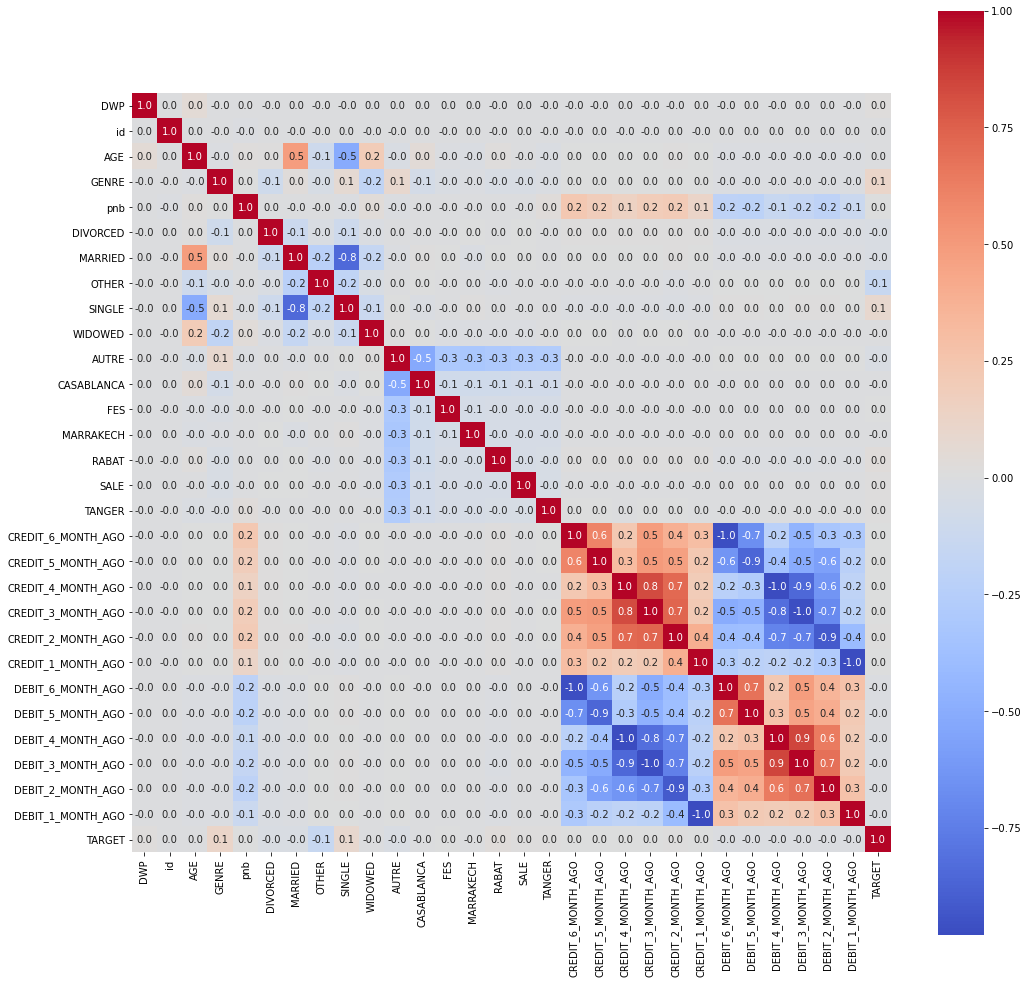

In [56]:
plt.figure(figsize=(17, 17))
g = sns.heatmap(dffinal.corr(), annot=True, cmap='coolwarm', square=True, fmt='.1f')

### Upload the new database

In [67]:
dffinal.to_csv("dffinal.csv")

# Model Training

In [68]:
df_train = dffinal[dffinal.DWP <= 201901]
df_test = dffinal[dffinal.DWP > 201901]


In [69]:
from sklearn.ensemble import RandomForestClassifier #library for machine learning / ensemble = Methode d'ensemble

y= df_train.TARGET
x= df_train.drop(["TARGET",'id',"DWP"],axis = 1).values


## Random Forest

In [71]:
RF_classifier = RandomForestClassifier()


In [72]:
# Fit : entrainer le modele (x,y) / Predict : recoie en parametre seulement les x (un modele deja existe)

RF_classifier.fit(x,y)


RandomForestClassifier()

In [73]:
x_test = df_test.drop(["TARGET",'id',"DWP"],axis = 1).values
RF_classifier.predict(x_test)


array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [75]:
prediction = RF_classifier.predict(x_test)
prediction2 = RF_classifier.predict_proba(x_test)


## Logistic Regression

In [78]:
from sklearn.linear_model import LogisticRegression
model_logistic = LogisticRegression()
model_logistic.fit(x, y)

C:\Users\Mohammed\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [79]:
y_pred_logistic = model_logistic.decision_function(x)

# Evaluation of the model

## Random Forest

In [76]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
t = df_train.drop(["id","DWP"],axis = 1)
print(classification_report(t.TARGET,  RF_classifier.predict(t.loc[:, t.columns != 'TARGET'])))


              precision    recall  f1-score   support

           0       0.99      0.99      0.99   1699987
           1       0.93      0.96      0.95    309818

    accuracy                           0.98   2009805
   macro avg       0.96      0.98      0.97   2009805
weighted avg       0.98      0.98      0.98   2009805



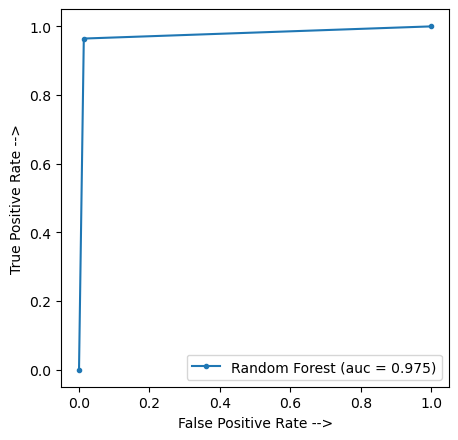

In [77]:
from sklearn.metrics import roc_curve, auc

RF_fpr, RF_tpr, threshold = roc_curve(t.TARGET, RF_classifier.predict(t.loc[:, t.columns != 'TARGET']))
auc_RF = auc(RF_fpr, RF_tpr)


plt.figure(figsize=(5, 5), dpi=100)

plt.plot(RF_fpr, RF_tpr, marker='.', label='Random Forest (auc = %0.3f)' % auc_RF)

plt.xlabel('False Positive Rate -->')
plt.ylabel('True Positive Rate -->')

plt.legend()

plt.show()


In [82]:
print(auc_RF)


0.9754894375007358


## Logistic Regression

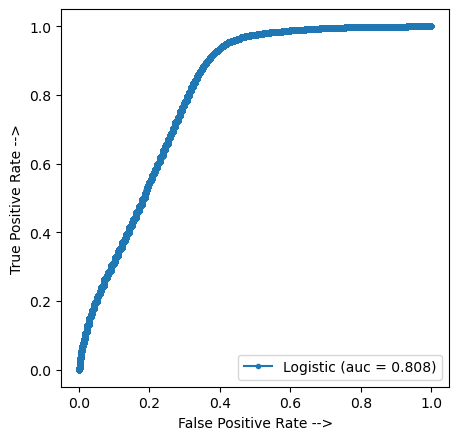

In [80]:
from sklearn.metrics import roc_curve, auc



logistic_fpr, logistic_tpr, threshold = roc_curve(t.TARGET, y_pred_logistic)
auc_logistic = auc(logistic_fpr, logistic_tpr)

plt.figure(figsize=(5, 5), dpi=100)


plt.plot(logistic_fpr, logistic_tpr, marker='.', label='Logistic (auc = %0.3f)' % auc_logistic)
plt.xlabel('False Positive Rate -->')
plt.ylabel('True Positive Rate -->')

plt.legend()

plt.show()

In [81]:
print(auc_logistic)

0.8076597872726788
